In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import scipy
from multiprocessing import Pool
import statsmodels.api as sm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import sys
sys.path.append("/nfs/stak/users/vuonga2/codes/ddpm_torch")

In [3]:
from sde_ddpm import DDPM, SimpleModel

In [13]:
device = "cuda:0"
T=500
lrate = 1e-4
n_epoch = 100

ddpm = DDPM(
    nn_model=SimpleModel(256),
    beta1=0.0001,
    beta2=0.02,
    T=T,
    device=device,
)

total_params = sum([p.numel() for p in ddpm.parameters()])
print("Model initialized, total params = ", total_params)
ddpm.to(device)

Model initialized, total params =  331778


DDPM(
  (nn_model): SimpleModel(
    (t_emb): Sequential(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_emb): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (out1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=256, out_features=256, bias=True)
    )
    (out2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (loss_mse): MSELoss

In [5]:
# draw x from gaussian mixtures
class_mean = [0, -10, 10]
class_var = [1, 2, 3]
class_probs = [0.4, 0.35, 0.25]

if np.sum(class_probs) != 1.0:
    raise("Total class probs should be 1.0")

In [6]:
N = 10000
s = np.random.multivariate_normal([0,0],[[1,0],[0,1]], N)

begin = 0
for idx, cl in enumerate(class_probs):
    end = begin + int(N*cl)
    s[begin:end] = class_mean[idx] + np.sqrt(class_var[idx])*s[begin:end]
    begin = end 
xs, ys = s[:,0], s[:,1]

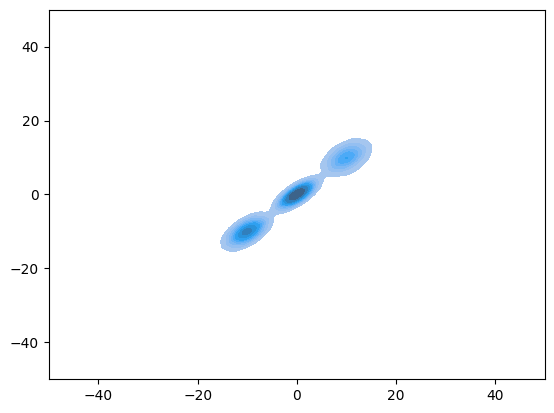

In [7]:
sns.kdeplot(x=xs, y=ys, fill=True)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

In [8]:
# define number of steps and noise schedule
T = 1000
sigma = np.linspace(0.01, 0.2, T)

# perform noising
s_all = [s]
s_t = s
for idx in tqdm.tqdm(range(1,T)):
    n = np.random.multivariate_normal([0,0],[[1,0],[0,1]], N)
    s_t_next = np.sqrt(1-sigma[idx])*s_t + np.sqrt(sigma[idx])*n
    s_t = s_t_next
    s_all.append(s_t)
    
s_noised = s_t
s_all = np.array(s_all)

xs_noised, ys_noise = s_noised[:,0], s_noised[:,1]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1658.02it/s]


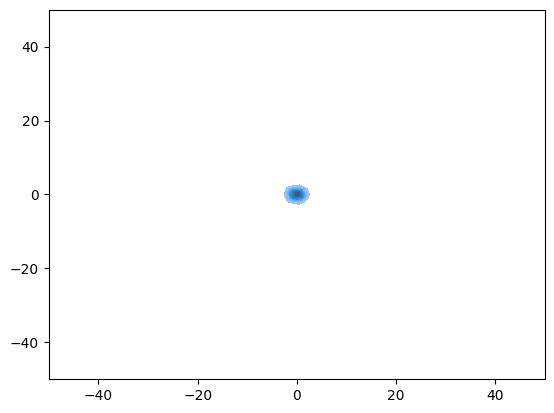

In [9]:
sns.kdeplot(x=s_noised[:,0], y=s_noised[:,1], fill=True)
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

In [14]:
ddpm.load_state_dict(torch.load("../data/2d_gaussians/model_250.pth"))

<All keys matched successfully>

In [20]:
xsample, x_gen_store = ddpm.sample(2000, [2], "cuda:0", True)

In [21]:
xsample = xsample.detach().cpu().numpy()

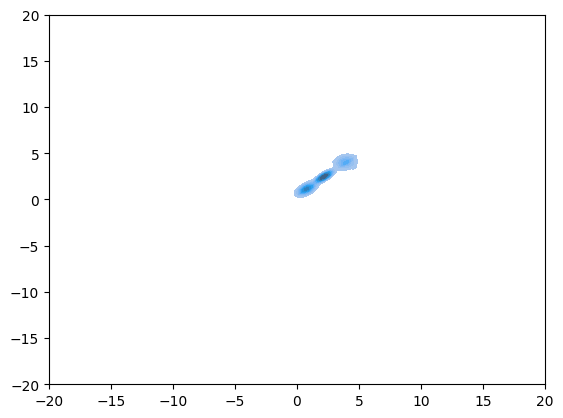

In [22]:
sns.kdeplot(x=x_gen_store[30][:,0], y=x_gen_store[30][:,1], fill=True)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

In [23]:
from matplotlib.animation import FuncAnimation, PillowWriter

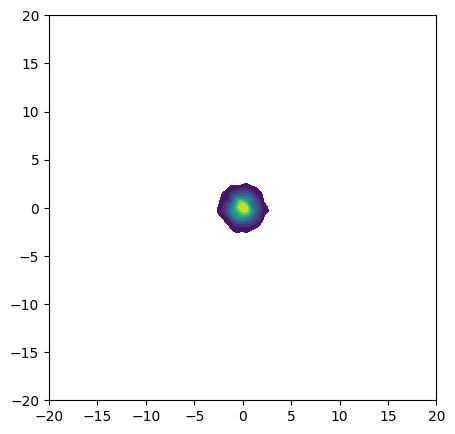

In [24]:
# create gif of images evolving over time, based on x_gen_store
def animate_diff(i, x_gen_store):
    plt.cla()
    plots = sns.kdeplot(x=x_gen_store[i][:,0], y=x_gen_store[i][:,1], fill=True, cmap="viridis")
    plots.set_xlim(-20, 20)
    plots.set_ylim(-20, 20)
    return plots

fig = plt.figure(figsize=(5,5))
plt.clf()

ani = FuncAnimation(
    fig,
    animate_diff,
    fargs=[x_gen_store],
    interval=200,
    blit=False,
    repeat=True,
    frames=x_gen_store.shape[0],
)
ani.save(
    f"gif_2d_gaussian.gif",
    dpi=100,
    writer=PillowWriter(fps=5),
)